# Projet 7 - Implémentez un modèle de scoring
Utilisation d'un Kernel pour gagner du temps sur le préprocessing et le feature engineering du dataset.
## Imports

In [1]:
import numpy as np
import pandas as pd
import gc
import time
import shutil
from contextlib import contextmanager

from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             classification_report, make_scorer,
                             precision_recall_curve, PrecisionRecallDisplay)
from sklearn.model_selection import (learning_curve, GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
import mlflow
from mlflow.tracking import MlflowClient
import shap
import joblib
from mlflow.models.signature import infer_signature

from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_row', 800)
pd.set_option("display.max_columns", None)
set_config(display="text")
sns.set_theme(style='whitegrid', palette='pastel')

## Accès aux données

In [3]:
import mlflow

chemin = r"C:\Users\saidi\Test\Data\\"
mlflow_path = r"file:///C:/Users/saidi/Test/mlruns"
mlflow.set_tracking_uri(mlflow_path)


## Fonctions

In [4]:
@contextmanager
def timer(title):
    """Compteur de durée"""
    
    t0 = time.time()
    yield
    print("{} - fait en {:.0f}s".format(title, time.time() - t0))

def one_hot_encoder(df, nan_as_category = True):
    """One-hot encoding for categorical columns with get_dummies"""
    
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, dtype=int)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def application_train_test(num_rows = None, nan_as_category = False):
    """Preprocess application_train.csv and application_test.csv"""


    # Read data and merge
    df = pd.read_csv(chemin+r'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(chemin+r'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # df = df.append(test_df).reset_index()
    df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

def bureau_and_balance(num_rows = None, nan_as_category = True):
    """Preprocess bureau.csv and bureau_balance.csv"""
    
    bureau = pd.read_csv(chemin+r'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(chemin+r'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

def previous_applications(num_rows = None, nan_as_category = True):
    """Preprocess previous_applications.csv"""
    
    prev = pd.read_csv(chemin+r'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

def pos_cash(num_rows = None, nan_as_category = True):
    """Preprocess POS_CASH_balance.csv"""
    
    pos = pd.read_csv(chemin+r'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
def installments_payments(num_rows = None, nan_as_category = True):
    """Preprocess installments_payments.csv"""
    
    ins = pd.read_csv(chemin+r'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

def credit_card_balance(num_rows = None, nan_as_category = True):
    """Preprocess credit_card_balance.csv"""
    
    cc = pd.read_csv(chemin+r'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

def main(debug = False):
    """Fonction principale appelant les fonctions précédentes"""
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    return df

## Lancement du kernel

In [5]:
with timer("______________________________________________________________________\nFull préprocessing & Feature engineering"):
    data = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - fait en 34s
Previous applications df shape: (338857, 249)
Process previous_applications - fait en 40s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - fait en 23s
Installments payments df shape: (339587, 26)
Process installments payments - fait en 34s
Credit card balance df shape: (103558, 141)
Process credit card balance - fait en 27s
______________________________________________________________________
Full préprocessing & Feature engineering - fait en 168s


## Observations préliminaires

In [6]:
df = data.copy()

In [7]:
df.shape

(356251, 797)

In [8]:
df.head(5)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

In [9]:
df.tail(5)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

In [10]:
df.sample(5)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

In [11]:
df.dtypes.value_counts()

float64    622
int32      133
int64       42
Name: count, dtype: int64

In [12]:
# Taux de manquants par colonnes
df.isna().mean().sort_values(ascending=False)

REFUSED_AMT_DOWN_PAYMENT_MIN                                             0.852343
REFUSED_RATE_DOWN_PAYMENT_MIN                                            0.852343
REFUSED_RATE_DOWN_PAYMENT_MEAN                                           0.852343
REFUSED_AMT_DOWN_PAYMENT_MEAN                                            0.852343
REFUSED_RATE_DOWN_PAYMENT_MAX                                            0.852343
REFUSED_AMT_DOWN_PAYMENT_MAX                                             0.852343
REFUSED_APP_CREDIT_PERC_VAR                                              0.836584
CC_AMT_PAYMENT_CURRENT_VAR                                               0.799012
CC_AMT_DRAWINGS_ATM_CURRENT_VAR                                          0.798760
CC_CNT_DRAWINGS_POS_CURRENT_VAR                                          0.798760
CC_AMT_DRAWINGS_POS_CURRENT_VAR                                          0.798760
CC_CNT_DRAWINGS_ATM_CURRENT_VAR                                          0.798760
CC_AMT_DRAWINGS_

In [13]:
# Valeurs dupliquées
df.duplicated().sum()

0

In [14]:
# Valeurs dupliquées sur colonnes hors Target
df.drop(columns='TARGET').duplicated().sum()

0

In [15]:
df.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

<Axes: ylabel='proportion'>

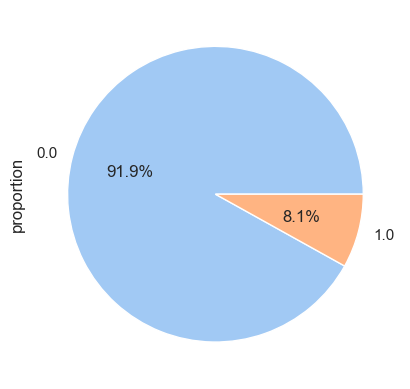

In [16]:
df['TARGET'].value_counts(normalize=True).plot(kind='pie', autopct='%.1f%%')

In [17]:
# Colonnes potentiellement inutiles, faute de variation des valeurs
df.nunique().sort_values()

PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN                                          1
PREV_NAME_CONTRACT_STATUS_nan_MEAN                                            1
PREV_CODE_REJECT_REASON_nan_MEAN                                              1
CC_NAME_CONTRACT_STATUS_Approved_MIN                                          1
POS_NAME_CONTRACT_STATUS_nan_MEAN                                             1
BURO_CREDIT_ACTIVE_nan_MEAN                                                   1
BURO_CREDIT_CURRENCY_nan_MEAN                                                 1
CC_NAME_CONTRACT_STATUS_Refused_MIN                                           1
BURO_CREDIT_TYPE_nan_MEAN                                                     1
BURO_STATUS_nan_MEAN_MEAN                                                     1
PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN                                      1
CC_NAME_CONTRACT_STATUS_nan_VAR                                               1
PREV_NAME_CONTRACT_TYPE_nan_MEAN        

## Préparation des données

### Fonctions de préparation

In [18]:
def reduction_taille_entier(df):
    """Transforme les entiers type 'int64' en type 'int32'."""
    
    df[df.columns[df.dtypes == 'int64']] = df[df.columns[df.dtypes == 'int64']].astype(dtype=np.int32, copy=False)
    return df

In [19]:
def suppression_colonnes_nan(df, taux_nan=0.8):
    """Suppression des variables avec trop de manquants"""
    
    df = df[df.columns[df.isna().mean() < taux_nan]]
        
    return df

In [20]:
def suppression_modalite_unique(df):
    """Suppression des variables avec une seule modalité"""
    
    col = df.columns[df.nunique() > 1].tolist()
    df = df[col]
    return df, col

In [21]:
def separation_dataframe(df):
    """Séparation du dataframe en train et test correspondant aux dataframes du départ :
       application_train et application_test.
       Sauvegarde du dataframe_test en imputant les manquants pour usage ultérieur via format JSON.
       Renvoi du dataframe_train pour la suite de la modélisation."""
    
    dataframe_train = df[df['TARGET'].notnull()]
    dataframe_test = df[df['TARGET'].isnull()]
    dataframe_train, colonnes_une_modalite = suppression_modalite_unique(dataframe_train)
    dataframe_test = dataframe_test[colonnes_une_modalite]
    
    dataframe_test = dataframe_test.drop(columns={'TARGET'})
    imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
    dataframe_test = pd.DataFrame(imputer.fit_transform(dataframe_test),
                                  index=dataframe_test.index,
                                  columns=dataframe_test.columns)
    print("Dataframe avec target shape: {}, dataframe sans target shape: {}".format(dataframe_train.shape, dataframe_test.shape))
    dataframe_test['SK_ID_CURR'] = dataframe_test['SK_ID_CURR'].astype(dtype=np.int32, copy=False)
    dataframe_test.to_csv(chemin+"cleaned/"+"dataframe_test.csv", sep=',', index=False)
    del dataframe_test, df
    gc.collect()
    return dataframe_train

In [22]:
def dataframe_split(df):
    """Séparation du dataframe en 2 dataframes :
    - trainset
    - testset
    puis re-split de la target dans chacun des sets"""
    
    df = df.drop(columns={'SK_ID_CURR'})
    trainset , testset = train_test_split(df, test_size=0.3, random_state=39)
    X_train = trainset.drop(columns={'TARGET'})
    y_train = trainset['TARGET']
    X_test = testset.drop(columns={'TARGET'})
    y_test = testset['TARGET']
    print("Répartition de la target sur le jeu d'entraînement :")
    print(y_train.value_counts())
    print("Répartition de la target sur le jeu de test :")
    print(y_test.value_counts())
    del df, trainset, testset
    gc.collect()
    return X_train, y_train, X_test, y_test

In [23]:
def clean_infini(df):
    """Remplacement des valeurs 'infini' par des 'NaN'"""
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [24]:
def preparation(df, taux_nan=0.8):
    """Fonction finalisant le pré-processing et renvoyant les 4 jeux d'entraînement et test"""
    
    with timer("Remplacement des valeurs 'int64' par des 'int32'"):
        df = reduction_taille_entier(df)
    with timer("Remplacement des valeurs 'infini' par des 'NaN'"):
        df = clean_infini(df)
    with timer("Suppression des variables avec trop de manquants"):
        df = suppression_colonnes_nan(df, taux_nan=0.8)
    with timer("Séparation du dataframe initial en dataframe_train et dataframe_test\npuis sauvegarde"):
        dataframe_train = separation_dataframe(df)
    with timer("Séparation du dataframe_train en trainset et testset"):
        X_train, y_train, X_test, y_test = dataframe_split(dataframe_train)
    
    
    return X_train, y_train, X_test, y_test

In [25]:
with timer("____________________________________________________\nPréparation finale des données"):
    X_train, y_train, X_test, y_test = preparation(df, taux_nan=0.8)

Remplacement des valeurs 'int64' par des 'int32' - fait en 0s
Remplacement des valeurs 'infini' par des 'NaN' - fait en 1s
Suppression des variables avec trop de manquants - fait en 1s
Dataframe avec target shape: (307507, 759), dataframe sans target shape: (48744, 758)
Séparation du dataframe initial en dataframe_train et dataframe_test
puis sauvegarde - fait en 61s
Répartition de la target sur le jeu d'entraînement :
TARGET
0.0    197758
1.0     17496
Name: count, dtype: int64
Répartition de la target sur le jeu de test :
TARGET
0.0    84924
1.0     7329
Name: count, dtype: int64
Séparation du dataframe_train en trainset et testset - fait en 14s
____________________________________________________
Préparation finale des données - fait en 77s


## Fonctions d'évaluation

In [26]:
def confusion(y_test, y_pred):
    """Affiche la matrice de confusion"""
    
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    plt.figure(figsize = (2, 2))
    plt.title('Matrice de confusion')
    sns.heatmap(mat, annot=True, cmap="Blues", fmt='0g', cbar=False)
    plt.show()
    return mat

In [27]:
def roc_auc(y_true, y_pred_proba):
    """Trace la courbe ROC et calcule le score ROC AUC"""
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color='red', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

In [28]:
def fonction_metier(y_true, y_pred):
    """Création d'un score métier : minimisation du coût d’erreur de prédiction des FN et FP (pondération 10 contre 1)"""
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sm = (10*fn+fp)
    return sm

In [29]:
def evaluation(model):
    """Evaluation d'un modèle affichant :
        - la matrice de confusion
        - le score métier
        - la courbe ROC avec le score ROC AUC"""
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    confusion(y_test, y_pred)
    score_metier = fonction_metier(y_test, y_pred)
    print("\nScore métier =", score_metier, "\n(Le meilleur est le plus bas)")
    print("\n________________\nRapport de classification")
    print(classification_report(y_test, y_pred))
    roc_auc(y_test, y_pred_proba)
    return score_metier

## Modélisation
### Dummy classifier

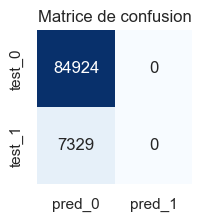


Score métier = 73290 
(Le meilleur est le plus bas)

________________
Rapport de classification


C:\Users\saidi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saidi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saidi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84924
         1.0       0.00      0.00      0.00      7329

    accuracy                           0.92     92253
   macro avg       0.46      0.50      0.48     92253
weighted avg       0.85      0.92      0.88     92253



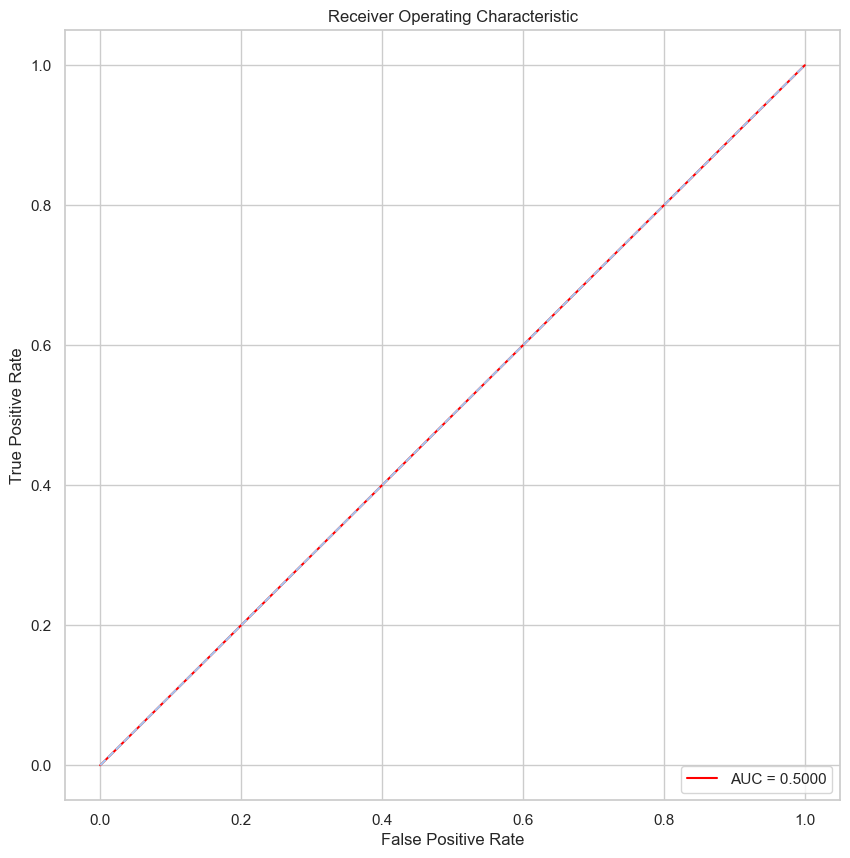

73290

In [30]:
estimator = DummyClassifier(strategy='most_frequent')
evaluation(estimator)

### Modèles à tester

In [31]:
preprocessor = make_pipeline(SimpleImputer(missing_values = np.nan, strategy='median'),
                             SelectKBest(f_classif, k='all'))

In [32]:
RandomForest = make_pipeline(preprocessor,
                             RandomForestClassifier(class_weight='balanced',
                                                    random_state=39,
                                                    n_jobs=-1))

LogisticRegression = make_pipeline(preprocessor,
                                   StandardScaler(),
                                   LogisticRegression(class_weight='balanced',
                                                      random_state=39,
                                                      n_jobs=-1))

XGBoost = make_pipeline(preprocessor,
                        XGBClassifier(scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
                                      random_state=39,
                                      n_jobs=-1))

LightGBM = make_pipeline(preprocessor,
                         LGBMClassifier(class_weight='balanced',
                                        random_state=39,
                                        n_jobs=-1))

In [33]:
dict_of_models = {'RandomForest': RandomForest,
                  'LogisticRegression': LogisticRegression,
                  'XGBoost': XGBoost,
                  'LightGBM': LightGBM
                 }

----------------------------------------------------------------------

Modèle : RandomForest


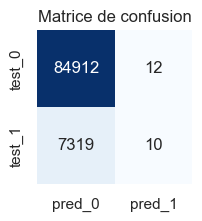


Score métier = 73202 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84924
         1.0       0.45      0.00      0.00      7329

    accuracy                           0.92     92253
   macro avg       0.69      0.50      0.48     92253
weighted avg       0.88      0.92      0.88     92253



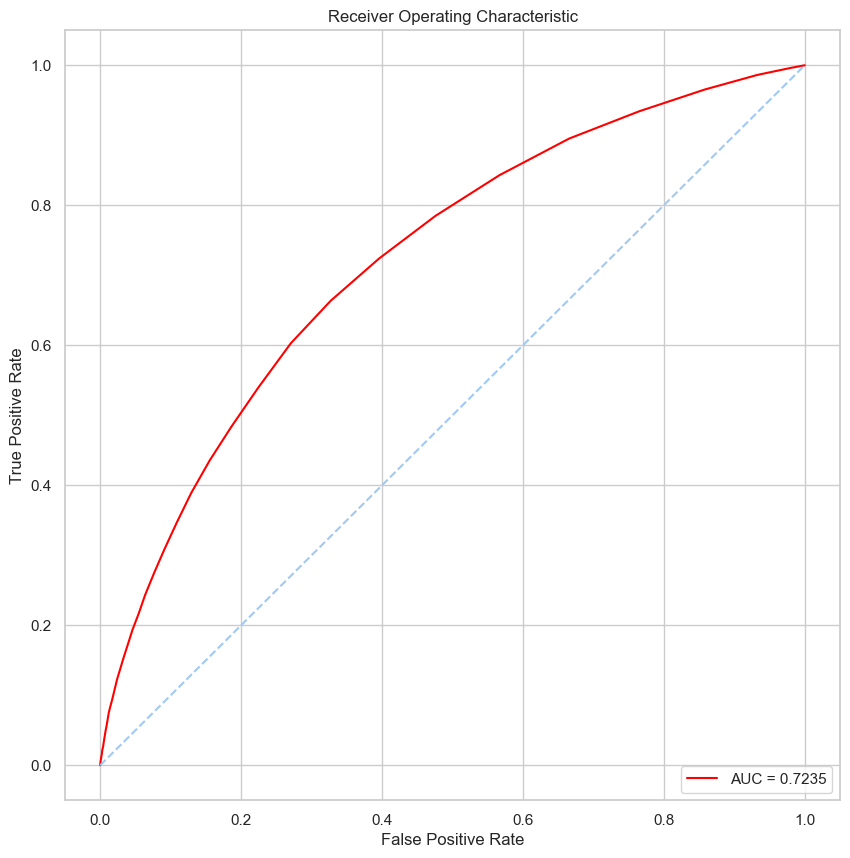

Modèle - fit, predict, scores - fait en 190s
----------------------------------------------------------------------

Modèle : LogisticRegression


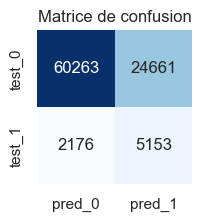


Score métier = 46421 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82     84924
         1.0       0.17      0.70      0.28      7329

    accuracy                           0.71     92253
   macro avg       0.57      0.71      0.55     92253
weighted avg       0.90      0.71      0.77     92253



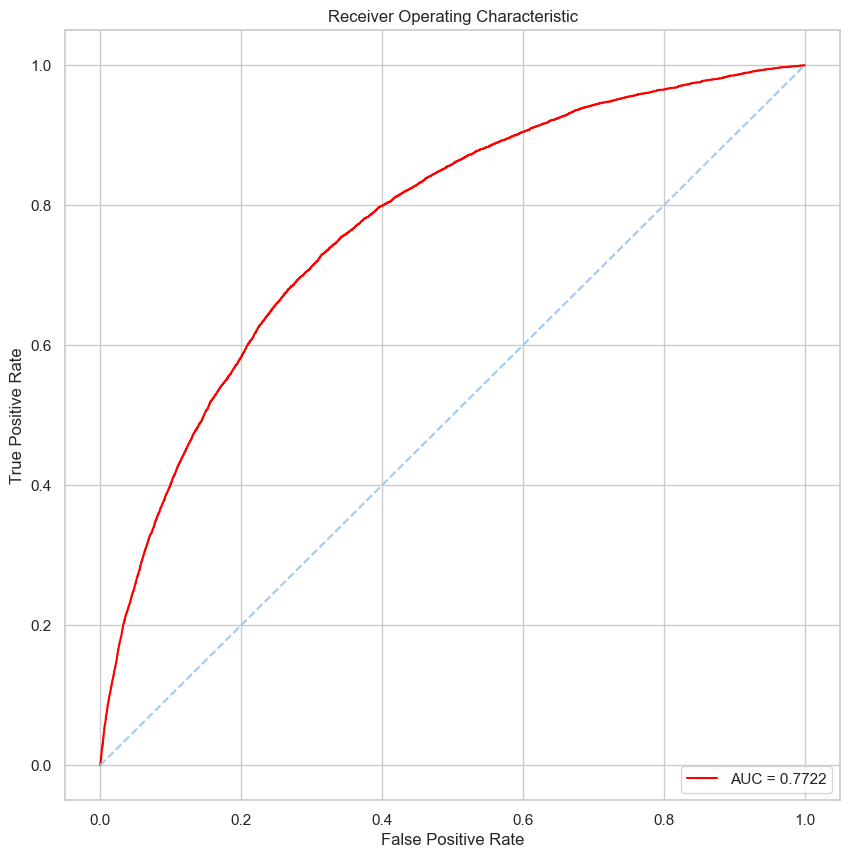

Modèle - fit, predict, scores - fait en 66s
----------------------------------------------------------------------

Modèle : XGBoost


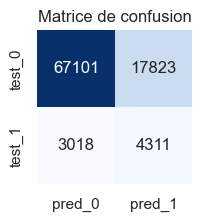


Score métier = 48003 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87     84924
         1.0       0.19      0.59      0.29      7329

    accuracy                           0.77     92253
   macro avg       0.58      0.69      0.58     92253
weighted avg       0.90      0.77      0.82     92253



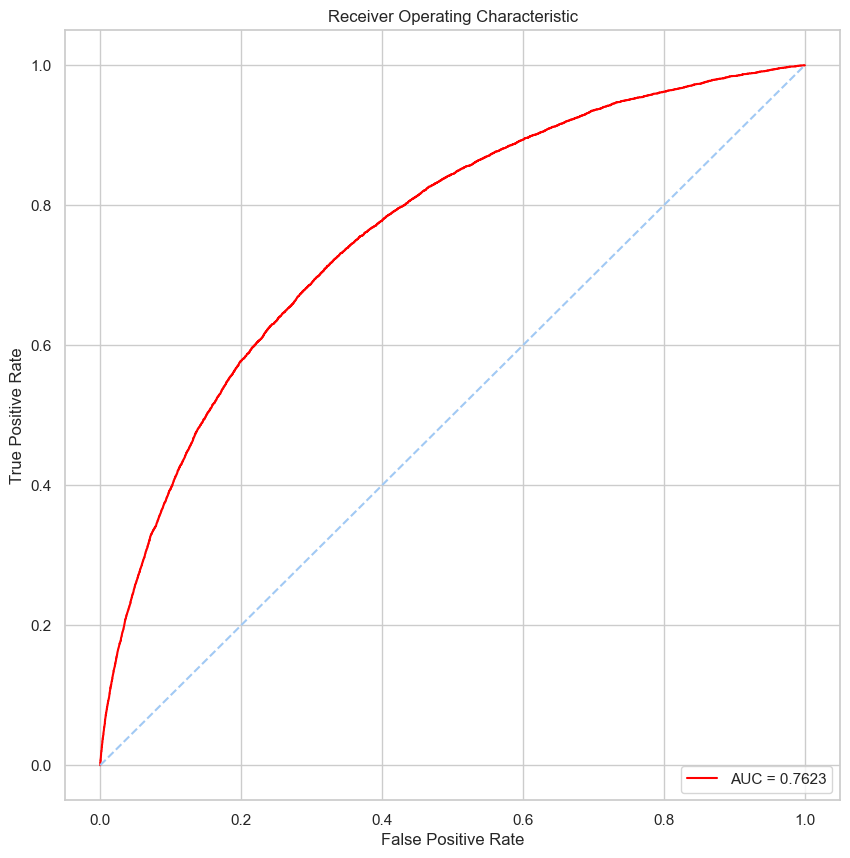

Modèle - fit, predict, scores - fait en 112s
----------------------------------------------------------------------

Modèle : LightGBM


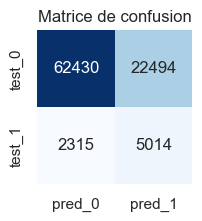


Score métier = 45644 
(Le meilleur est le plus bas)

________________
Rapport de classification
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83     84924
         1.0       0.18      0.68      0.29      7329

    accuracy                           0.73     92253
   macro avg       0.57      0.71      0.56     92253
weighted avg       0.90      0.73      0.79     92253



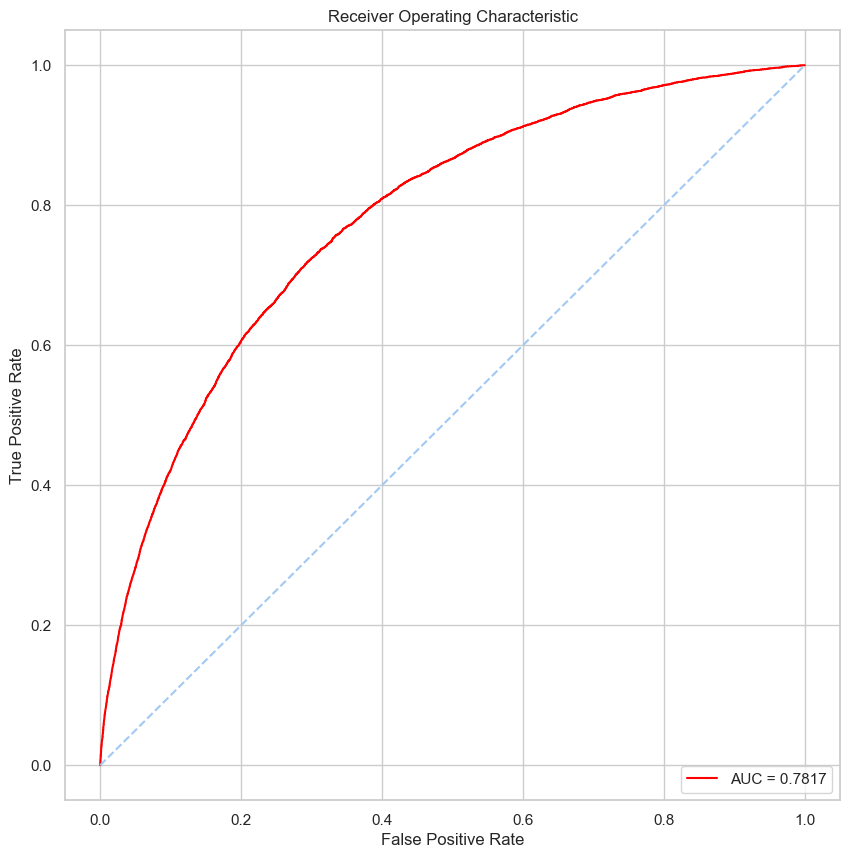

Modèle - fit, predict, scores - fait en 135s


In [34]:
for name, model in dict_of_models.items():
    with timer("Modèle - fit, predict, scores"):
        print('-'*70)
        print('\nModèle :', name)
        evaluation(model)

Actuellement, les **meilleurs résultats** sont apportés par **LightGBM**, en termes de scores métier et AUC et aussi en temps de calculs.

Mais, il est possible d'améliorer tous les modèles.
## Optimisation des modèles par validation croisée

In [35]:
hyper_params_modeles = {'RandomForest': {'randomforestclassifier__n_estimators': [10, 200],
                                         'randomforestclassifier__criterion': ['gini', 'entropy'],
                                         'randomforestclassifier__max_depth': [3, 6]},
                        'LogisticRegression': {'logisticregression__solver': ['newton-cholesky', 'sag']},
                        'XGBoost': {'xgbclassifier__max_depth': [2, 6],
                                    'xgbclassifier__subsample': [0.1, 1],
                                    'xgbclassifier__colsample_bytree': [0.1, 1]},
                        'LightGBM': {'lgbmclassifier__n_estimators': [10, 200],
                                     'lgbmclassifier__max_depth': [2, 30],
                                     'lgbmclassifier__colsample_bytree': [0.1, 1]}
                       }

Transformation de la fonction métier en score métier à utiliser comme scoring de la validation croisée :

In [36]:
score_metier = make_scorer(fonction_metier, greater_is_better=False)

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, classification_report, roc_auc_score as roc_auc
import time

# Set the experiment
mlflow.set_experiment("mlflow_tracking")

def optimisation(model, name):
    # Démarrer une session MLflow pour le modèle
    with mlflow.start_run(run_name=name) as parent_run:
        start_time = time.time()  # Début du chronométrage

        # GridSearchCV pour la recherche des meilleurs hyperparamètres
        grid = GridSearchCV(model, hyper_params_modeles[name], scoring=score_metier, cv=3, n_jobs=-1, return_train_score=True)
        grid.fit(X_train, y_train)

        end_time = time.time()  # Fin du chronométrage
        duration = end_time - start_time  # Durée en secondes

        # Pour chaque configuration d'hyperparamètres testée
        for i in range(len(grid.cv_results_['params'])):
            # Créer un sous-run pour chaque ensemble d'hyperparamètres
            with mlflow.start_run(run_name=f"{name}_params_{i+1}", nested=True) as child_run:
                params = grid.cv_results_['params'][i]
                mean_train_score = grid.cv_results_['mean_train_score'][i]
                std_train_score = grid.cv_results_['std_train_score'][i]
                mean_test_score = grid.cv_results_['mean_test_score'][i]
                std_test_score = grid.cv_results_['std_test_score'][i]
                
                # Log des hyperparamètres et scores de validation croisée
                mlflow.log_params(params)
                mlflow.log_metric("mean_train_score", mean_train_score)
                mlflow.log_metric("std_train_score", std_train_score)
                mlflow.log_metric("mean_test_score", mean_test_score)
                mlflow.log_metric("std_test_score", std_test_score)
                
                print(f"Configuration {i+1}/{len(grid.cv_results_['params'])}: {params}")
                print(f"Mean train score: {mean_train_score} (+/-{std_train_score*2})")
                print(f"Mean test score: {mean_test_score} (+/-{std_test_score*2})")

        # Enregistrer les meilleurs résultats pour le modèle
        y_pred_proba_train = grid.best_estimator_.predict_proba(X_train)[:, 1]
        y_pred_proba_test = grid.best_estimator_.predict_proba(X_test)[:, 1]
        y_pred = grid.best_estimator_.predict(X_test)

        score_metier_test = fonction_metier(y_test, y_pred)
        auc_train = roc_auc(y_train, y_pred_proba_train)
        auc_test = roc_auc(y_test, y_pred_proba_test)

        mlflow.log_params(grid.best_params_)
        mlflow.log_metric("score_metier_test", score_metier_test)
        mlflow.log_metric("auc_train", auc_train)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("duration", duration)

        # Enregistrement du rapport de classification dans MLflow
        report = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                for metric_name, metric_value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric_name}", metric_value)
            else:
                mlflow.log_metric(f"{label}", metrics)

        # Enregistrement du modèle entraîné dans MLflow
        mlflow.sklearn.log_model(grid.best_estimator_, "best_model")

        print("\nMeilleurs hyper-paramètres :")
        print(grid.best_params_)
        print(f"Score métier sur le jeu de test: {score_metier_test}")
        print(f"AUC sur le jeu d'entraînement: {auc_train}")
        print(f"AUC sur le jeu de test: {auc_test}")
        print(f"Durée de l'entraînement (s): {duration}")



In [ ]:
# Boucle pour chaque modèle
for nom, modele in dict_of_models.items():
    print('-'*90)
    print(nom)
    optimisation(modele, nom)

C'est finalement le modèle **LightGBM** qui obient les meilleurs scores, qu'il s'agisse de l'AUC sur le jeu de test et surtout du score métier.

C'est donc c'est algorithme que je vais tenter d'optimiser pour gagner encore plus de performance, à l'aide de **RandomizedSearchCV**.
## Optimisation poussée de l'algorithme LGBMClassifier
Je réalise un tracking des expériences avec **MLFlow** afin d'affiner le modèle au fil de l'eau sur plusieurs jours si besoin en m'appuyant sur les résultats passés avec une méthode en entonnoir.
### Hyper-paramètres et leur *range* à tester

## Optimisation supplémentaire avec le seuil de décision
A présent, la liste des runs de l'expérience - visible avec **MLFlow UI** - fournit le meilleur modèle et ses hyperparamètres.

Je le charge afin de déterminer le seuil de décision qui fournira le meilleur score métier.

In [38]:
# ID de l'expérience et ID du run spécifique où le modèle a été sauvegardé
experiment_id = '979992215999366617'  # Remplacez par votre ID d'expérience
run_id = '94f6a42f08914d0282cd864836bb4df7'  # Remplacez par l'ID du run spécifique

# Charger le modèle depuis l'expérience et le run spécifique
model_uri = f"runs:/{run_id}/best_model"  # Chemin au modèle
perfect_model = mlflow.sklearn.load_model(model_uri)

# Maintenant, vous pouvez utiliser le modèle chargé


In [39]:
precision, recall, threshold = precision_recall_curve(y_test, perfect_model.predict_proba(X_test)[:,1])

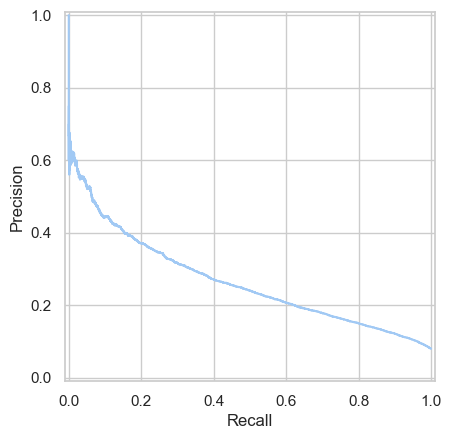

In [40]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [41]:
def model_final(model, X, threshold=0.5):
    """Renvoie la classe en fonction de la probabilité de target et du seuil de décision"""
    
    return model.predict_proba(X)[:,1] >= threshold

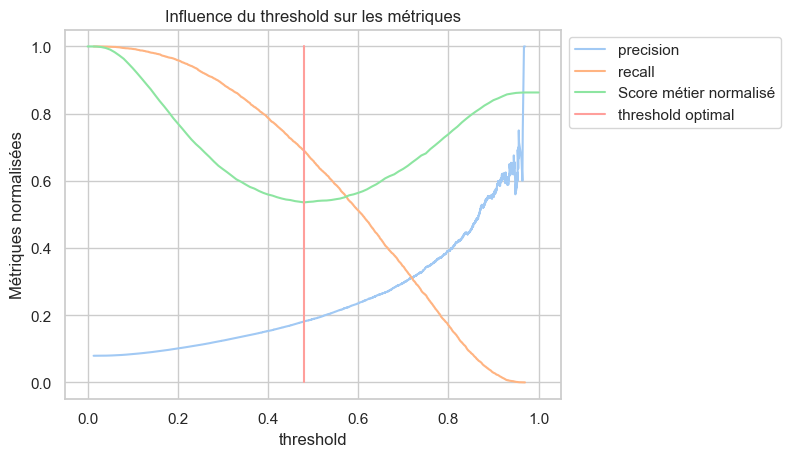

Score métier optimal de 45504 (0.54 normalisé) pour un threshold de 0.48


In [42]:
thres=[]
scor_met=[]
for th in np.linspace(0, 1, 101):
    y_pred = model_final(perfect_model, X_test, threshold=th)
    s_m = fonction_metier(y_test, y_pred)
    thres.append(th)
    scor_met.append(s_m)
    
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
tab = pd.DataFrame({'seuil': thres, 'score métier': scor_met})
plt.plot(thres, tab['score métier']/tab['score métier'].max(), label='Score métier normalisé')
seuil_sc_min = tab['seuil'].loc[tab['score métier'] == tab['score métier'].min()]
plt.plot((seuil_sc_min, seuil_sc_min), (0, 1), label='threshold optimal')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('threshold')
plt.ylabel('Métriques normalisées')
plt.title('Influence du threshold sur les métriques')
plt.show()
print("Score métier optimal de {} ({:.2f} normalisé) pour un threshold de {:.2f}".format(
            tab['score métier'].min(),
            tab['score métier'].min()/tab['score métier'].max(),
            tab['seuil'][tab['score métier'].argmin()]))

Le score métier ci-dessus est déterminé en faisant varier le threshold par pas de 0,01.

Il est possible d'affiner pour trouver le threshold le plus précis donnant un score métier le plus bas possible.

In [43]:
thres=[]
scor_met=[]
for th in np.linspace(0.490979, 0.490989, 5):
    y_pred = model_final(perfect_model, X_test, threshold=th)
    s_m = fonction_metier(y_test, y_pred)
    thres.append(th)
    scor_met.append(s_m)
    
tab = pd.DataFrame({'seuil': thres, 'score métier': scor_met})
best_score_metier = tab['score métier'][2]
best_threshold = tab['seuil'][2]
print("Score métier le plus bas = {}\npour threshold = {:.6f}".format(
            best_score_metier,
            best_threshold))
tab

Score métier le plus bas = 45673
pour threshold = 0.490984


,seuil,score métier
0,0.490979,45673
1,0.490982,45673
2,0.490984,45673
3,0.490986,45672
4,0.490989,45671


## Pipeline de prédiction
### Apprentissage de la pipeline sur l'ensemble des données issues du application_train

In [44]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [45]:
perfect_model.fit(X, y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median')),
                                 ('selectkbest', SelectKBest(k='all'))])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.1,
                                max_depth=30, n_estimators=200,
                                random_state=39))])

## Sérialisation de la pipeline

In [46]:
joblib.dump(perfect_model, 'pipeline_lgbm.joblib')

['pipeline_lgbm.joblib']

## Déploiement d'un modèle sklearn avec MLflow
### Signature d'un modèle

In [47]:
signature = infer_signature(X, y)

C:\Users\saidi\anaconda3\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


### Sauvegarde du modèle sklearn

In [48]:
# Supprimer le dossier s'il existe déjà
shutil.rmtree('mlflow_model', ignore_errors=True)

# Sauvegarder le modèle
mlflow.sklearn.save_model(perfect_model, 'mlflow_model', signature=signature, pyfunc_predict_fn='predict_proba')

## Optimisation ultime avec le seuil de décision
Le seuil de décision peut encore être affiné avec cette modélisation sur l'ensemble du dataset.

In [49]:
precision, recall, threshold = precision_recall_curve(y, perfect_model.predict_proba(X)[:,1])

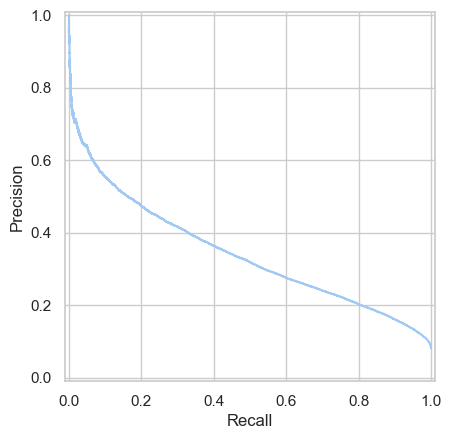

In [50]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

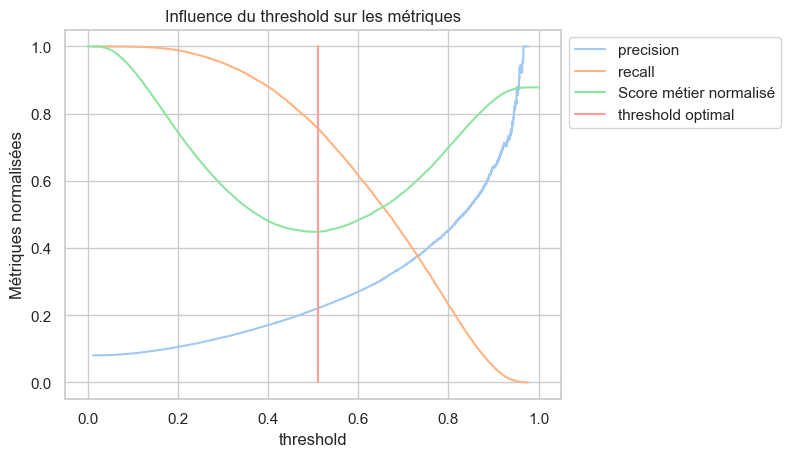

Score métier optimal de 126660 (0.45 normalisé) pour un threshold de 0.51


In [51]:
thres=[]
scor_met=[]
for th in np.linspace(0, 1, 101):
    y_pred = model_final(perfect_model, X, threshold=th)
    s_m = fonction_metier(y, y_pred)
    thres.append(th)
    scor_met.append(s_m)
    
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
tab = pd.DataFrame({'seuil': thres, 'score métier': scor_met})
plt.plot(thres, tab['score métier']/tab['score métier'].max(), label='Score métier normalisé')
seuil_sc_min = tab['seuil'].loc[tab['score métier'] == tab['score métier'].min()]
plt.plot((seuil_sc_min, seuil_sc_min), (0, 1), label='threshold optimal')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('threshold')
plt.ylabel('Métriques normalisées')
plt.title('Influence du threshold sur les métriques')
plt.show()
print("Score métier optimal de {} ({:.2f} normalisé) pour un threshold de {:.2f}".format(
            tab['score métier'].min(),
            tab['score métier'].min()/tab['score métier'].max(),
            tab['seuil'][tab['score métier'].argmin()]))

Le score métier ci-dessus est déterminé en faisant varier le threshold par pas de 0,01.

Il est possible d'affiner pour trouver le threshold le plus précis donnant un score métier le plus bas possible.

In [52]:
thres=[]
scor_met=[]
for th in np.linspace(0.517823, 0.517829, 5):
    y_pred = model_final(perfect_model, X, threshold=th)
    s_m = fonction_metier(y, y_pred)
    thres.append(th)
    scor_met.append(s_m)
    
tab = pd.DataFrame({'seuil': thres, 'score métier': scor_met})
best_score_metier = tab['score métier'][2]
best_threshold = tab['seuil'][2]
print("Score métier le plus bas = {}\npour threshold = {:.6f}".format(
            best_score_metier,
            best_threshold))
tab

Score métier le plus bas = 126961
pour threshold = 0.517826


,seuil,score métier
0,0.517823,126962
1,0.517825,126962
2,0.517826,126961
3,0.517827,126961
4,0.517829,126960


## Résultats globaux du modèle final

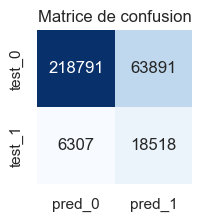


Score métier = 126961 
(Le meilleur est le plus bas)

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86    282682
         1.0       0.22      0.75      0.35     24825

    accuracy                           0.77    307507
   macro avg       0.60      0.76      0.60    307507
weighted avg       0.91      0.77      0.82    307507



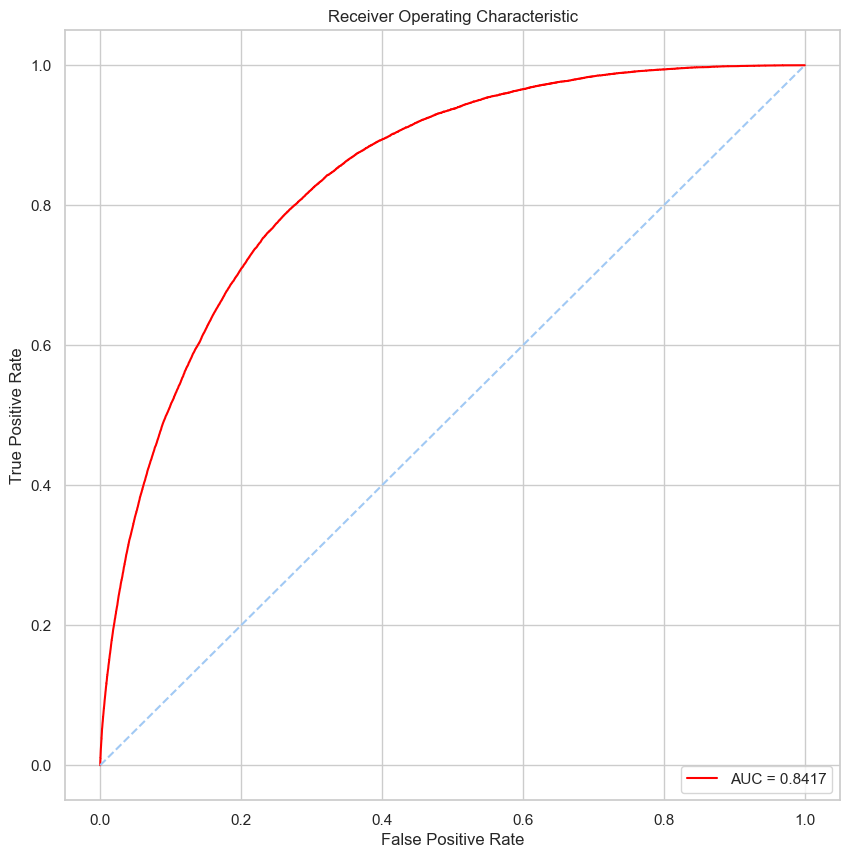

0.8416751521053056

In [53]:
y_pred = model_final(perfect_model, X, threshold=best_threshold)
y_pred_proba = perfect_model.predict_proba(X)[:,1]
matrice_confusion = confusion(y, y_pred)
score_metier = fonction_metier(y, y_pred)
print("\nScore métier =", score_metier, "\n(Le meilleur est le plus bas)")
print()
print(classification_report(y, y_pred))
roc_auc(y, y_pred_proba)

Remarque : l'AUC obtenu ci-dessus n'a pas d'intérêt puisqu'on est sur un modèle ré-entraîné avec l'ensemble des données !!!

## Interprétation des prédictions à l'aide des SHAP Values

### Création d'un Explainer
Basé sur 100 observations aléatoires de l'*application_test*, qui serviront aussi d'échantillons pour le dashboard, afin de réduire le temps de calcul.

In [54]:
application_test = pd.read_csv(chemin+"cleaned/"+"dataframe_test.csv")
application_test = application_test.sample(100)

In [55]:
print(application_test.drop(columns={'SK_ID_CURR'}).shape)


(100, 757)


In [56]:
with timer("Explainer"):
    f = lambda x: perfect_model.predict_proba(x)[:,1]
    med = X.median().values.reshape((1, X.shape[1]))
    explainer = shap.Explainer(f, med)
    shap_values = explainer(application_test.drop(columns={'SK_ID_CURR'}), max_evals=1595)

C:\Users\saidi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\saidi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\saidi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\saidi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\saidi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
C:\Users\saidi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid featur

Explainer - fait en 20s


### Interprétabilité globale

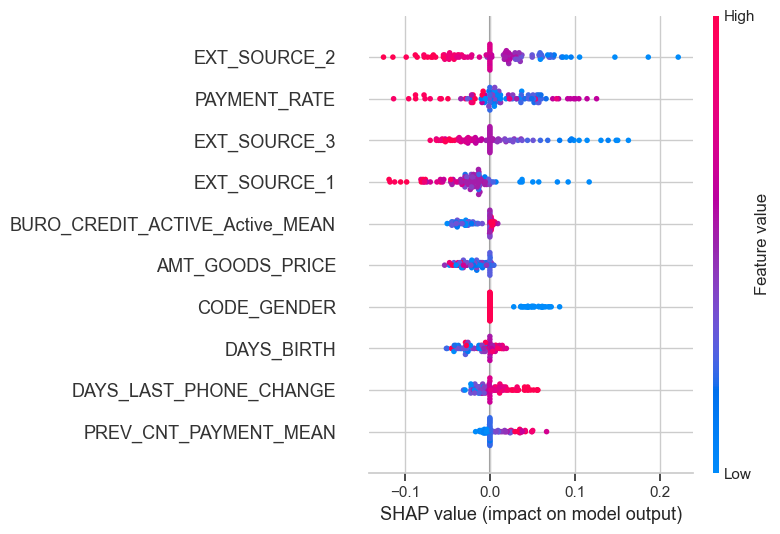

In [57]:
shap.summary_plot(shap_values, max_display=10)

### Interprétabilité locale d'un client

**Waterfall Plot**

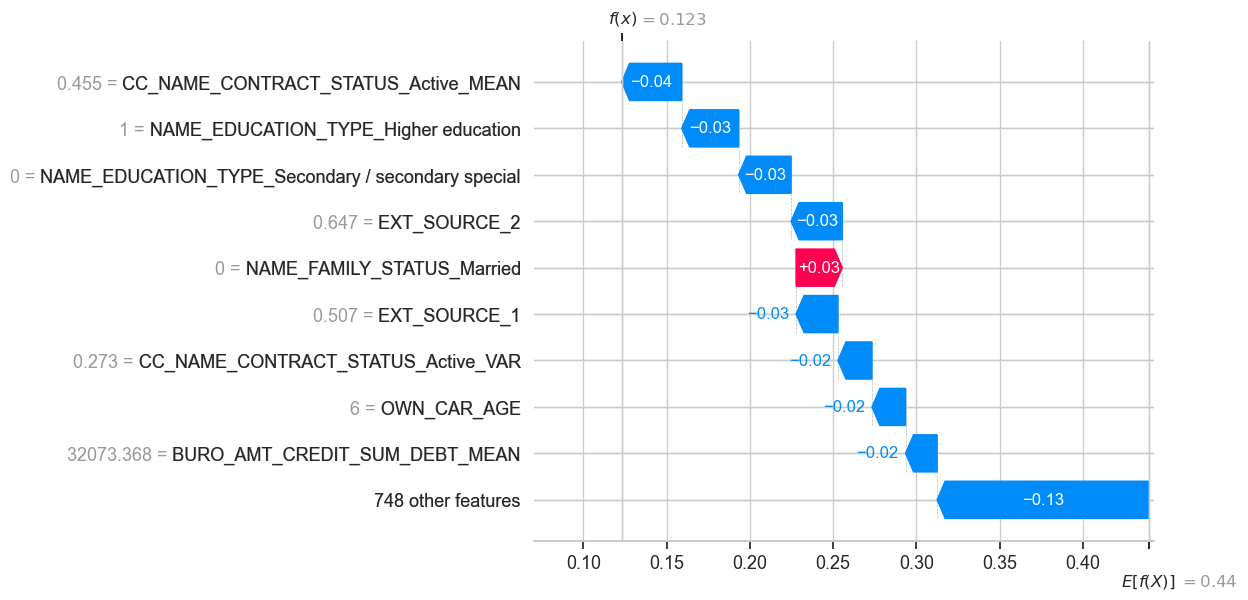

In [58]:
shap.plots.waterfall(shap_values[0], max_display=10)

#### Enregistrement d'échantillons pour usage avec le dashboard
J'en profite pour transmettre le *best_threshold* nécessaire pour déterminer la classe de chaque client à partir de sa probabilité de faillite.

In [59]:
application_test['threshold'] = best_threshold
application_test.to_csv("./data/echantillon_clients.csv", sep=',', index=False)
application_test.to_csv("./Streamlit/echantillon_clients.csv", sep=',', index=False)

Je crée un échantillon qui servira au dashboard pour afficher la dispersion des variables en fonction de la target.

Je vérifie qu'il y a suffisamment de target 1.

In [60]:
echantillon_dispersion = pd.merge(y_test, X_test, left_index=True, right_index=True).sample(2000)
echantillon_dispersion['TARGET'].value_counts()

TARGET
0.0    1840
1.0     160
Name: count, dtype: int64

In [61]:
echantillon_dispersion.to_csv("./Streamlit/trainset.csv", sep=',', index=False)